In [1]:
import pandas as pd

# DBSCAN
Desity based spatial classification of anplication with noise

In [2]:
data=pd.read_excel("https://data.hossam.kr/G02/customer.xlsx")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   고객ID    200 non-null    int64 
 1   성별      200 non-null    object
 2   나이      200 non-null    int64 
 3   연수입     200 non-null    int64 
 4   지출점수    200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


불필요 column 제거

In [4]:
data.drop("고객ID",inplace=True,axis=1)

성별 encoding 

In [5]:
data["성별"]=data["성별"].apply(lambda x:1 if x=="Male" else 0)

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
성별,200.0,0.44,0.497633,0.0,0.00,0.0,1.0,1.0
나이,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
연수입,200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
지출점수,200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0


In [7]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.rcParams["font.family"]="BM YEONSUNG"

## 시각화

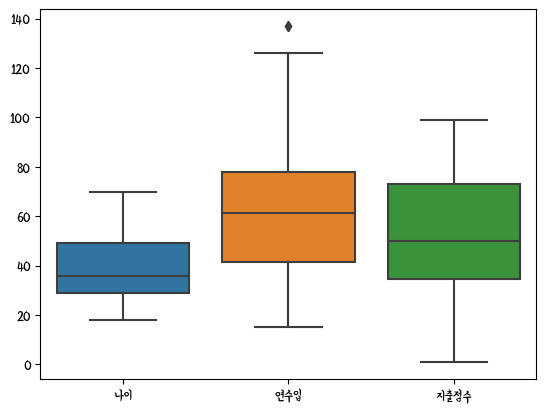

In [8]:
cols=data.columns.difference(["성별"])
plt.figure()
sb.boxplot(data[cols])
plt.show()
plt.close()

<Figure size 640x480 with 0 Axes>

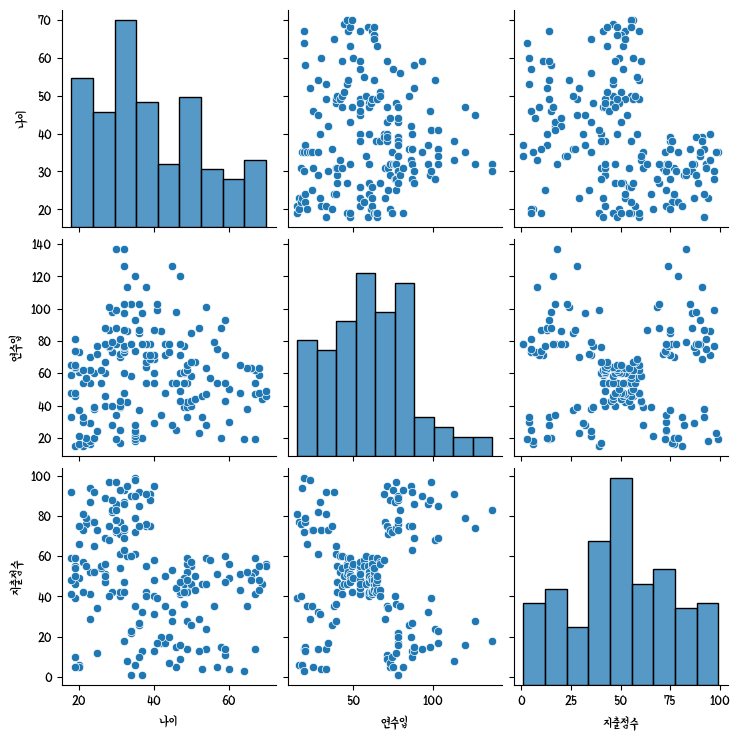

In [9]:
plt.figure()
sb.pairplot(data[cols])
plt.show()
plt.close()

* 시각화 결과
> 이상치, 결측치 등은 발견되자않았지만, `DBscan`방식은 이상치에 강한 모델이므로 상관없다고 판단

## 모델생성

* Dbscan에서 `eps`값을 결정하기 위해서 표준화를 진행하겠음(굳이 하지 않아도 `DBscan`은 작동할것)

In [10]:
import sklearn.preprocessing as skpre

In [11]:
pre_data=pd.merge(data,pd.DataFrame(skpre.minmax_scale(X=data[cols]),columns=list(map(lambda x:"pre_"+x,cols))),left_index=True,right_index=True)

* eps값, min_samples 후보
> eps : [0.3,0.5] 중 하나를 고를것(점점 일반화)              
> min_samples : [5,7] 중 하나를 고를것(점점 정규화,즉 일반화에서 멀어지게)

In [12]:
import sklearn.cluster as skclu
import sklearn.model_selection as skmod
import sklearn.metrics as skmet
import tqdm

모델 학습

In [13]:
use_cols=list(map(lambda x:"pre_"+x,cols))

In [14]:
params=[]
result_model=[]
for eps in [0.3,0.5]:
    for min_samples in [5,7]:
        params.append([eps,min_samples])
with tqdm.tqdm(total=len(params),unit='B',unit_scale=True) as precess_bar:
    for x in params:
        try:
            model=skclu.DBSCAN(eps=x[0],min_samples=x[1]).fit(X=pre_data[use_cols+["성별"]])
            score=skmet.silhouette_score(X=pre_data[use_cols],labels=model.labels_)
            result_model.append({'para':x,'model':model,'silhouette_score':score}) # 실루엣 계수는 DBscan에서 크게 유효하지 않음
            precess_bar.update()
        except:
            continue 

100%|██████████| 4.00/4.00 [00:00<00:00, 104B/s]


In [15]:
result=pd.DataFrame([x['model'].labels_ for x in result_model]).T.rename(columns=dict(zip(range(4),list(map(lambda x:f'(eps={x[0]},min_samples={x[1]})',params)))))

In [16]:
result.head(3)

,"(eps=0.3,min_samples=5)","(eps=0.3,min_samples=7)","(eps=0.5,min_samples=5)","(eps=0.5,min_samples=7)"
0,0,0,0,0
1,0,0,0,0
2,1,1,1,1


### 결과시각화

PCA 실시해서 차원축소해서 데이터의 분포를 보자

In [17]:
import pca

In [18]:
pca_model=pca.pca(n_components=2)
pca_result=pca_model.fit_transform(X=pre_data[use_cols+["성별"]])

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


In [48]:
pca_result["loadings"]

,pre_나이,pre_연수입,pre_지출점수,성별
PC1,0.052295,0.029466,-0.049065,0.996990
PC2,0.725476,-0.028423,-0.683998,-0.070875


In [34]:
visual_data=pd.merge(result,pre_data[use_cols+["성별"]]@(pca_result["loadings"].T),left_index=True,right_index=True)

In [36]:
visual_data.head(3)

,"(eps=0.3,min_samples=5)","(eps=0.3,min_samples=7)","(eps=0.5,min_samples=5)","(eps=0.5,min_samples=7)",PC1,PC2
0,0,0,0,0,0.978971,-0.322147
1,0,0,0,0,0.959955,-0.587386
2,1,1,1,1,-0.000250,-0.007228


> 시각화

C:\Users\SAMSUNG\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\SAMSUNG\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


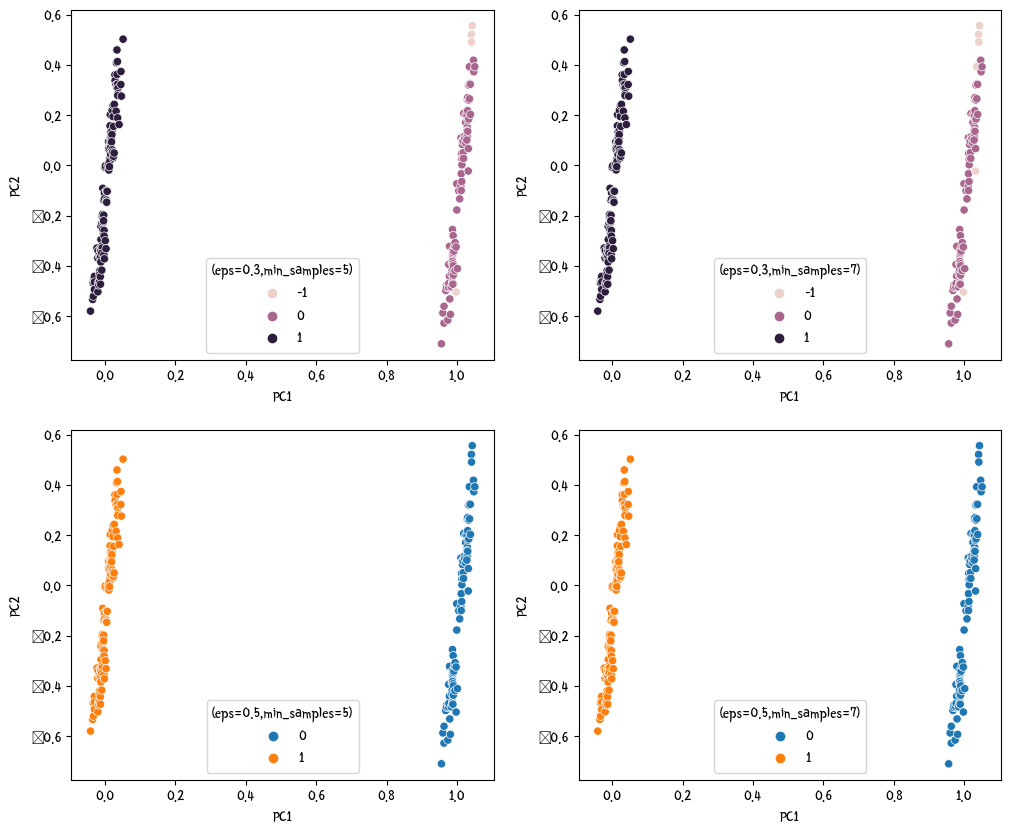

In [47]:
_,a=plt.subplots(2,2,figsize=(12,10))
a=sum(list(map(list,a)),[])
for i in range(4):
    sb.scatterplot(data=visual_data,x='PC1',y="PC2",hue=visual_data.columns[i],ax=a[i])

## 이상치 확인작업

> 위의 결과를 보아          
> `eps=0.3` 일때 min_sample 값에 따라 `noise`가 각각 다르게 발생하였음          
> `eps=0.5`일 경우 일반화가 굉장히 잘됌

- 가정 1            
두 그룹은 남,여로 나뉜다.

위의 가정을 확인해보자

In [52]:
noise_data=pd.merge(pre_data,visual_data,left_index=True,right_index=True).drop(['(eps=0.5,min_samples=5)','(eps=0.5,min_samples=7)'],axis=1)

In [54]:
noise_data.head(3)

,성별,나이,연수입,지출점수,pre_나이,pre_연수입,pre_지출점수,"(eps=0.3,min_samples=5)","(eps=0.3,min_samples=7)",PC1,PC2
0,1,19,15,39,0.019231,0.000000,0.387755,0,0,0.978971,-0.322147
1,1,21,15,81,0.057692,0.000000,0.816327,0,0,0.959955,-0.587386
2,0,20,16,6,0.038462,0.008197,0.051020,1,1,-0.000250,-0.007228


In [55]:
import sklearn.metrics as skmet

남녀로 나눌수있는지 accuracy 확인

In [56]:
skmet.accuracy_score(y_true=noise_data["성별"],y_pred=noise_data["(eps=0.3,min_samples=5)"].apply(lambda x:abs(x-1)))

0.98

In [57]:
skmet.accuracy_score(y_true=noise_data["성별"],y_pred=noise_data["(eps=0.3,min_samples=7)"].apply(lambda x:abs(x-1)))

0.97

사실 당연한 결과이다. 왜냐하면 pca 수행중 `성별`에 곱해지는 $\beta$ 값이 굉장히 컸으므로..

그렇다면 이상치들을 뽑아보자

In [58]:
noise_data[noise_data["(eps=0.3,min_samples=5)"]==-1]

,성별,나이,연수입,지출점수,pre_나이,pre_연수입,pre_지출점수,"(eps=0.3,min_samples=5)","(eps=0.3,min_samples=7)",PC1,PC2
8,1,64,19,3,0.884615,0.032787,0.020408,-1,-1,1.043216,0.556001
10,1,67,19,14,0.942308,0.032787,0.132653,-1,-1,1.040726,0.521080
30,1,60,30,4,0.807692,0.122951,0.030612,-1,-1,1.041350,0.490653
199,1,30,137,83,0.230769,1.000000,0.836735,-1,-1,0.997470,-0.504206


In [59]:
noise_data[noise_data["(eps=0.3,min_samples=7)"]==-1]

,성별,나이,연수입,지출점수,pre_나이,pre_연수입,pre_지출점수,"(eps=0.3,min_samples=5)","(eps=0.3,min_samples=7)",PC1,PC2
8,1,64,19,3,0.884615,0.032787,0.020408,-1,-1,1.043216,0.556001
10,1,67,19,14,0.942308,0.032787,0.132653,-1,-1,1.040726,0.521080
30,1,60,30,4,0.807692,0.122951,0.030612,-1,-1,1.041350,0.490653
32,1,53,33,4,0.673077,0.147541,0.030612,0,-1,1.035035,0.392294
198,1,32,137,18,0.269231,1.000000,0.173469,0,-1,1.032024,-0.022631
199,1,30,137,83,0.230769,1.000000,0.836735,-1,-1,0.997470,-0.504206


위의 결과를 보아 둘간의 이상치 판단 기준은 다름.(당연한 얘기지만) min_sample=7일경우 덜 일반회되어 이상치의 기준이 강화되었음

과연 어느 model이 이상치를 탐색하기 좋은 모델인지 (eps가 다르다면 더욱 판단하기 어려웠겠지만; eps가 같다면 쉽게 판단될 문제)판단해보자

In [63]:
m1_homo,m1_com,m1_v=skmet.homogeneity_completeness_v_measure(labels_true=noise_data["성별"],labels_pred=noise_data["(eps=0.3,min_samples=5)"])
m2_homo,m2_com,m2_v=skmet.homogeneity_completeness_v_measure(labels_true=noise_data["성별"],labels_pred=noise_data["(eps=0.3,min_samples=7)"])

In [64]:
pd.DataFrame({"homogeneity":[m1_homo,m2_homo],"completeness":[m1_com,m2_com],"v-measure":[m1_v,m2_v]})

,homogeneity,completeness,v-measure
0,1.0,0.893965,0.944014
1,1.0,0.862316,0.926069


* 이해해보자면

|지표|설명|
|--|--|
|homogeneity|정밀도와 유사|
|completeness|무결성,재현율과 유사|
|v-measure|위의 조화평균|

위의 결과를 토대로 min_samples=5일때의 dbscan 모델을 이용해 이상치를 추정하겠음

* 아쉬운 점 

더 다양한 클러스터 기법끼리도 비교해보았으면 좋았을 듯